In [1]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages and repo if in colab
    !pip install ipywidgets &> /dev/null               
    !pip install neuron &> /dev/null

    !git clone https://github.com/GregGlickert/Neural-Modeling-Manual.git &> /dev/null 
    %cd Neural-Modeling-Manual/Chapter-3-Synaptic-Design/Section-2-Short-Term-Plasticity/

if(os.path.exists('x86_64')==False):        
    os.system('nrnivmodl modfiles') # compile modfiles. Return 0 for success, 1 for failure.

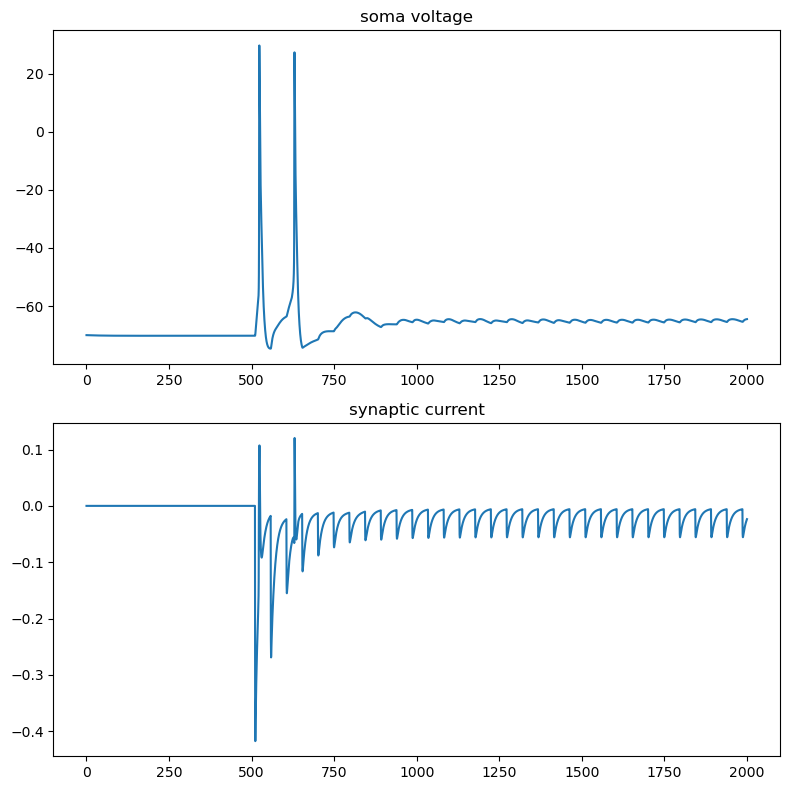

In [2]:
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
%matplotlib inline

def model(weight,input_freqency,Use,tau_f,tau_d):
    h.load_file('stdrun.hoc')
    h.load_file('PN_cells.hoc') # reads in template
    cell = h.PN_C() #cell from template file
    h.dt = 0.1 # time step (resolution) of the simulation in ms
    h.tstop = 2000 # how long to run the simulation in ms
    h.v_init= -70 # initial membrane potential in mV
    
    t = h.Vector()      # Vectors are used to record data in the simulation
    soma_v = h.Vector()
    i = h.Vector()

    conn = h.AMPA_NMDA_STP(cell.dend[0](0.9)) # makes a syn connected to soma
    conn.initW = weight #synaptic weight for our synapse

    conn.Fac = tau_f # faciliation parameter
    conn.Dep = tau_d # depression parameter
    conn.Use = Use   # inital efficacy


    nstim = h.NetStim(0.9)               # creating a stimulation for the cell

    nstim.interval=1000/input_freqency   # Hz of input
    nstim.start=500                      # when stim should start
    nstim.number = 100                   # 
    nstim.noise = 0                      # level of noise
    nc = h.NetCon(nstim,conn,10,10,1)
    
    
    
    t.record(h._ref_t) # derefences and records data
    soma_v.record(cell.soma[0](0.5)._ref_v)
    i.record(conn._ref_i)

    h.finitialize(h.v_init * mV)  # runs sims
    h.continuerun(h.tstop * ms)   
    
    plot_model(t,soma_v,i)
    
def plot_model(t,soma_v,i):         # ploting code
    fig = plt.figure(figsize=(8, 8),tight_layout=True) 
    gs = gridspec.GridSpec(2, 1, width_ratios=[1],height_ratios=[1,1]) 
    
    ax0 = plt.subplot(gs[0,0])  # top plot
    ax1 = plt.subplot(gs[1,0])  # bottom plot
    
    ax0.plot(t ,soma_v)
    ax0.set_title('soma voltage')
    
    ax1.plot(t,i)
    ax1.set_title('synaptic current')
    
    #ax2.plot(t,Pr)
    #ax2.set_title("running synaptic efficacy")
    

    plt.show()
    
weight = 14         # inital values used by the slider
input_freqency = 7  
Use = 1
tau_f = 10
tau_d = 100

# widgets the get displayed below
w_run = widgets.Button(description='Run',icon='history',button_style='primary')
w_dep_model = widgets.Button(description='Depressing syn',icon='history',button_style='')    
w_fac_model = widgets.Button(description='Faciliating syn',icon='history',button_style='')        
w_weight = widgets.FloatSlider(value=weight,min=0.001,max=50, step=0.2,description='syn weight',style=dict(description_width='initial'))
w_input_freqency = widgets.FloatSlider(value=input_freqency,min=0.001,max=50, step=1,description='Input Freq',style=dict(description_width='initial'))
w_Use = widgets.FloatSlider(value=Use,min=0.001,max=1, step=0.01,description='init efficacy',style=dict(description_width='initial'))
w_tau_f = widgets.FloatSlider(value=tau_f,min=0,max=2000, step=10,description='tau f',style=dict(description_width='initial'))
w_tau_d = widgets.FloatSlider(value=tau_d,min=0,max=2000, step=10,description='tau d',style=dict(description_width='initial'))

def run_model(*arges):
    clear_output()  #               Removes the sliders and then updated the values and displays the new valuesgit
    
    weight = w_weight.value
    input_freqency = w_input_freqency.value
    Use = w_Use.value
    tau_f = w_tau_f.value
    tau_d = w_tau_d.value
    display(ui)
    model(weight,input_freqency,Use,tau_f,tau_d)

def depressing_model(*arges):
    clear_output()
    print("changing synaptic values!")
    w_Use.value = 0.5
    w_tau_d.value = 800
    w_tau_f.value = 0
    display(ui)

def fac_model(*arges):
    clear_output()
    print("changing synaptic values!")
    w_Use.value = 0.03
    w_tau_d.value = 300
    w_tau_f.value = 1800
    display(ui)

w_run.on_click(run_model)
w_dep_model.on_click(depressing_model)
w_fac_model.on_click(fac_model) 
ui = VBox([HBox([w_run,w_dep_model,w_fac_model,w_Use]), HBox([w_weight,w_tau_f]),HBox([w_input_freqency,w_tau_d])])
ui

## synaptic short term plascity is based off this paper https://journals.physiology.org/doi/full/10.1152/jn.00258.2001